## Variable dependiente Binomial
Cuando se tiene como endogena a una variable binaria, no se puede estimar con un modelo lineal. La opcion mas adecuada es estimarse por un Probit o un Logit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

La base que se usara en todo este archivo es sobre la probabilidad de aceptacion a una universidad `admit` donde las explicativas son `gpa`, `gre` y `rank`. Las dos primeras son _Graduate Record Exam scores_ y _Grade Point Average_. El ultimo es el rango de prestigio del colegio

In [2]:
dta = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/binary.dta")
X = dta[["gre", "gpa", "rank"]]
y = dta["admit"]

dta.head()

,admit,gre,gpa,rank
0,0.0,380.0,3.61,3.0
1,1.0,660.0,3.67,3.0
2,1.0,800.0,4.00,1.0
3,1.0,640.0,3.19,4.0
4,0.0,520.0,2.93,4.0


### Probit

In [3]:
model = smf.probit("admit ~ gre + gpa + C(rank, Treatment(reference=1))", data=dta)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.573016
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                         Probit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 01 Jan 2023   Pseudo R-squ.:                 0.08313
Time:                        20:28:44   Log-Likelihood:                -229.21
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.219e-08
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.3868   

### Logit

In [4]:
model = smf.logit("admit ~ gre + gpa + C(rank, Treatment(reference=1))", data=dta)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 01 Jan 2023   Pseudo R-squ.:                 0.08292
Time:                        20:28:44   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -3.9900   

### Efectos marginales
Nos dan los coeficientes y efectos reales de cada variable sobre la probilidad de la endogena. Hacia adelante se usara los resultados del Logit. Los resultados se dividen principalmente de la siguiente manera:
1. `overall` (AME): Promedio de los marginales de cada observacion
2. `mean` (MEM): Efecto marginal de la observacion promedio

In [5]:
AME = results.get_margeff(at="overall", method="dydx")

print(AME.summary())

        Logit Marginal Effects       
Dep. Variable:                  admit
Method:                          dydx
At:                           overall
                                            dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(rank, Treatment(reference=1))[T.2.0]    -0.1314      0.060     -2.184      0.029      -0.249      -0.013
C(rank, Treatment(reference=1))[T.3.0]    -0.2608      0.062     -4.176      0.000      -0.383      -0.138
C(rank, Treatment(reference=1))[T.4.0]    -0.3019      0.076     -3.956      0.000      -0.451      -0.152
gre                                        0.0004      0.000      2.107      0.035    3.07e-05       0.001
gpa                                        0.1564      0.063      2.485      0.013       0.033       0.280


In [6]:
MEM = results.get_margeff(at="mean", method="dydx")

print(MEM.summary())

        Logit Marginal Effects       
Dep. Variable:                  admit
Method:                          dydx
At:                              mean
                                            dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(rank, Treatment(reference=1))[T.2.0]    -0.1415      0.067     -2.126      0.033      -0.272      -0.011
C(rank, Treatment(reference=1))[T.3.0]    -0.2807      0.072     -3.890      0.000      -0.422      -0.139
C(rank, Treatment(reference=1))[T.4.0]    -0.3250      0.087     -3.742      0.000      -0.495      -0.155
gre                                        0.0005      0.000      2.079      0.038    2.71e-05       0.001
gpa                                        0.1684      0.069      2.436      0.015       0.033       0.304


### ODDs-Ratio

In [7]:
print(np.exp(results.params))

Intercept                                 0.018500
C(rank, Treatment(reference=1))[T.2.0]    0.508931
C(rank, Treatment(reference=1))[T.3.0]    0.261792
C(rank, Treatment(reference=1))[T.4.0]    0.211938
gre                                       1.002267
gpa                                       2.234545
dtype: float64


### Evaluacion de ajuste
Se puede evaluar el ajuste del modelo mediante cuatro vias:
1. Pseudo R
2. Significancia conjunta
3. Matriz de confusion
4. Curva ROC

In [8]:
# Evaluacion 1
print(np.round(results.prsquared, 3))

0.083


In [9]:
# Evaluacion 2
print(np.round(results.llr_pvalue, 3))

0.0


In [10]:
# Evaluacion 3
prediction = results.predict(X)

cutoff = 0.5
y_hat = np.where(prediction > cutoff, 1, 0)

In [11]:
clasif = classification_report(y, y_hat)
print(clasif)

              precision    recall  f1-score   support

         0.0       0.72      0.93      0.81       273
         1.0       0.61      0.24      0.34       127

    accuracy                           0.71       400
   macro avg       0.67      0.58      0.58       400
weighted avg       0.69      0.71      0.66       400



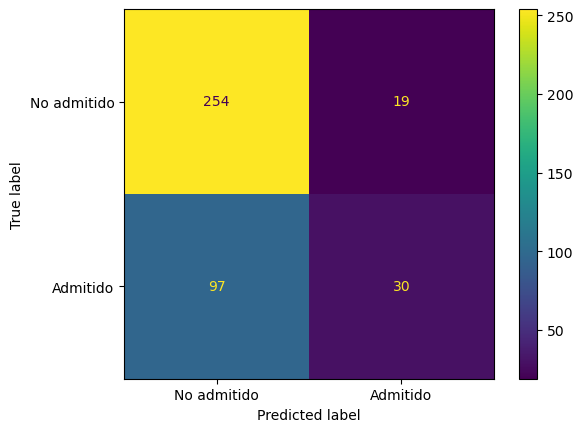

In [12]:
conf = confusion_matrix(y, y_hat)

conf_plot = ConfusionMatrixDisplay(
    confusion_matrix = conf,
    display_labels=["No admitido", "Admitido"]
)

conf_plot.plot()

plt.savefig("./figures/confusion_matrix.pdf")
plt.show()

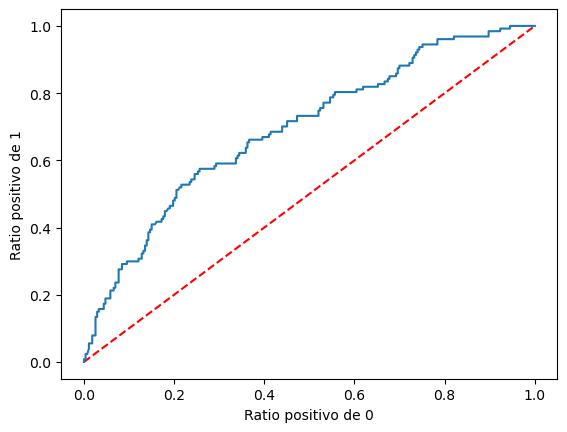

In [13]:
# Evaluacion 4
fpr, tpr, thresholds = roc_curve(y, prediction)
x45 = np.linspace(0, 1, 2)

plt.plot(x45, x45, color="red", linestyle="dashed")
plt.plot(fpr, tpr)

plt.xlabel("Ratio positivo de 0")
plt.ylabel("Ratio positivo de 1")
plt.savefig("./figures/roc.pdf")
plt.show()

### Referencias:
* https://medium.com/analytics-vidhya/logistic-regression-using-python-a5044843a504
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/